In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patheffects
import matplotlib as mpl
import numpy as np
import pandas as pd
import vice

from surp.analysis.apogee_analysis import subgiants
import seaborn as sns
from surp.analysis import plotting_utils as pluto
import surp

from surp._globals import AGB_MODELS
import arya
import scipy

from surp import yields
from surp.analysis import Z_SUN, MH_to_Z, Z_to_MH

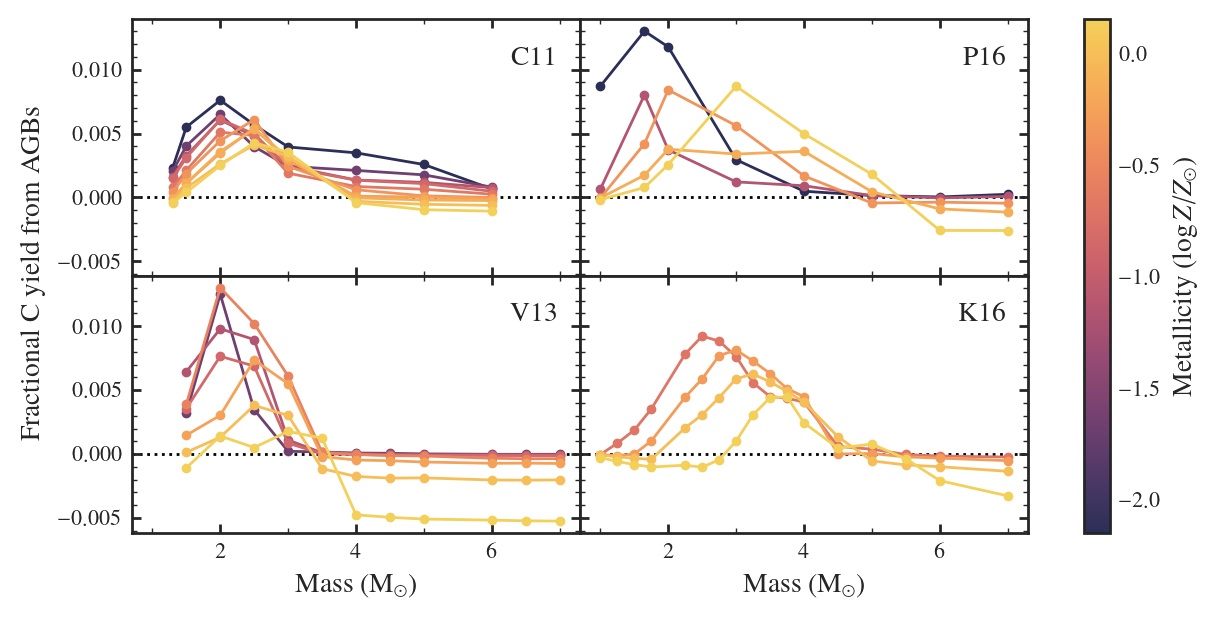

In [2]:
Z_max = 0.02
Z_min = 0.0001
AGB_LABELS = ["C11", "P16", "V13", "K16"]

hmap = arya.figure.colorbar.HueMap((np.log10(Z_min/0.014), np.log10(Z_max/0.014)))

def plot_c_table(study = "cristallo11", ax=None, fig=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]
        c = hmap(np.log10(z/0.014))
        f = ax.plot(m1, y, "o", label=f"Z = {z}", c=(c), **kwargs)
        f = ax.plot(m1, y, label=f"Z = {z}", c=(c), **kwargs)
        # ax.set_xticks(np.arange(1, 8))
    
    ax.axhline(0, color="k", ls=":", zorder=-1)

    return f


fig, axs = plt.subplots(2, 2, figsize=(7, 10/3), sharex=True, sharey=True, gridspec_kw={"hspace":0, "wspace": 0, "left": 0.1})
# plt.minorticks_off()

for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    ax = axs[i//2][i%2]
    f = plot_c_table(study, ax=ax, fig=fig)
    
    ax.text(0.95, 0.9, label, horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes)
    

# axes.set_position([left, Botton, width height])
# .get_position to set colorbar
# TODO: split axes to fix range
arya.Colorbar(huemap=hmap, ax=axs.ravel().tolist(), label=r"Metallicity ($\log Z/Z_\odot$)")


plt.setp(axs[-1, :], xlabel=r'Mass (${\rm M}_\odot$)')
fig.supylabel(r"Fractional C yield from AGBs")
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

plt.savefig("figures/agb_yields.pdf")

In [3]:
def plot_y_z(Zs, kind="line", **kwargs):
    mass_yields = []
    
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
        
    y_c_agb = np.array(mass_yields)/1e6 

    if kind == "line":
        return plt.plot(Z_to_MH(Zs), y_c_agb, **kwargs)
    elif kind == "scatter":
        return plt.scatter(Z_to_MH(Zs), y_c_agb, **kwargs)

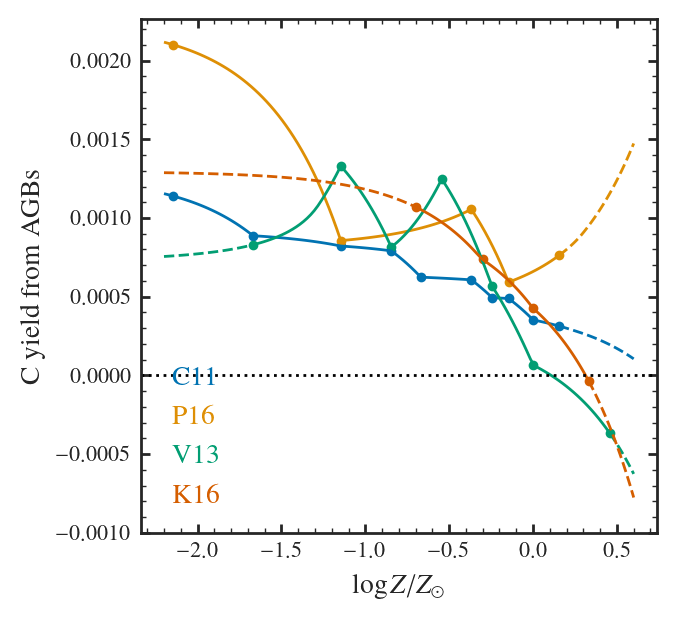

In [5]:
plt.figure(figsize=(10/3, 10/3))
x_min = -2.2
x_max = 0.6
N_points = 100

for i in range(4):
    model = AGB_MODELS[i]

    vice.yields.agb.settings["c"] = model
    vice.yields.ccsne.settings["c"] = 0
    
    # plots importaint points
    y1, m1, z1 = vice.yields.agb.grid('c', study=model)
    plot_y_z(z1, kind="scatter")
    
    # plot solid within range
    MoverH_min = Z_to_MH(min(z1))
    MoverH_max = Z_to_MH(max(z1))
    
    Zs = MH_to_Z(np.linspace(MoverH_min, MoverH_max, N_points))
    line, = plot_y_z(Zs, label=["C11", "P16", "V13", "K16"][i])
    color = line.get_color()

    Zs = MH_to_Z(np.linspace(x_min, MoverH_min, N_points))    
    plot_y_z(Zs, linestyle="--", color=color)

    Zs = MH_to_Z(np.linspace(MoverH_max, x_max, N_points))
    plot_y_z(Zs, linestyle="--", color=color)




# Zs = 0.014*10**np.linspace(-1, 0.5, 100)
# mass_yields = []
# vice.yields.agb.settings["c"] = surp.yields.a_agb(zeta_agb=-0.1)
# for Z in Zs:
#     m_c, times = vice.single_stellar_population("c", Z=Z)
#     mass_yields.append(m_c[-1])
    
# plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="-", color="red")



plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"C yield from AGBs")

plt.ylim(-0.001)
prop_cycle = plt.rcParams['axes.prop_cycle']

arya.Legend(color_only=True, handlelength=0)


plt.savefig("figures/y_agb_vs_z.pdf")

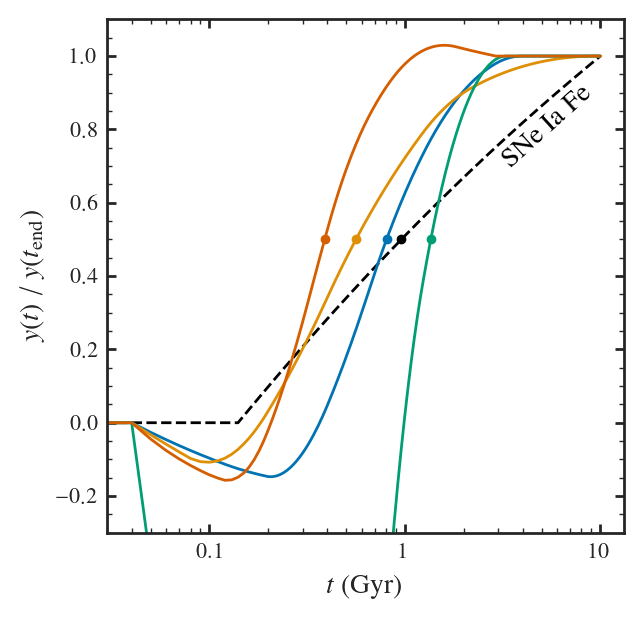

In [6]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
    y = np.array(m_c)/m_c[-1]
    plt.plot(times, y)
    
    f = scipy.interpolate.interp1d(y, times)
    plt.scatter(f(0.5), 0.5)
    

plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
y = np.array(m_fe)/m_fe[-1]
plt.plot(times, y, 
         linestyle="--", zorder=-1, color="k")
f = scipy.interpolate.interp1d(y, times)
plt.scatter(f(0.5), 0.5, color="k")


plt.xlabel(r"$t$ (Gyr)")
plt.ylabel(r"$y(t)\;/\;y(t_{\rm end})$")
plt.xscale("log")
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

plt.savefig("figures/y_agb_vs_t.pdf")

# Extra

In [ ]:
surp.yields.set_yields(mass_factor=1.5)
y_agb = vice.yields.agb.settings["c"]

for Z in MH_to_Z(np.linspace(-3, 0.5, 5)):
    N = 100
    Ms = np.linspace(1, 7, N)
    ys = np.zeros(N)
    
    for i in range(N):
        ys[i] = y_agb(Ms[i], Z)
    
    plt.plot(Ms, ys, color=hmap(Z_to_MH(Z)))

Yield settings
X       CC                            agb                           SN Ia
c       4.16e-03 + 1.19e-01 (Z - Z0)  2.04 × karakas16              0
n       7.20e-04                      0.00e+00 M + 9.00e-04 M Z/Z0  0
o       1.50e-02                      0                             0
mg      1.85e-03                      0                             0
fe      1.20e-03                      0                             1.70e-03




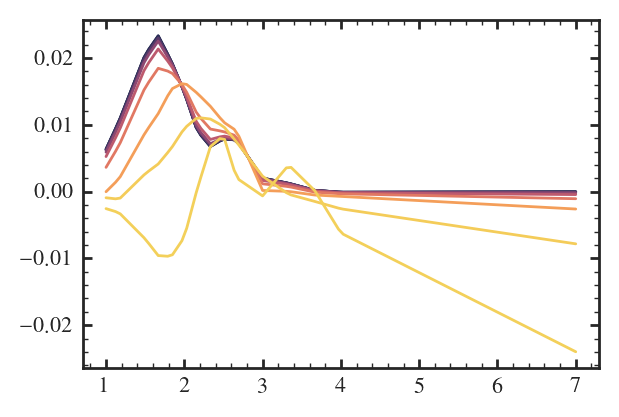

In [6]:
surp.yields.set_yields(agb_model="karakas16", mass_factor=1.5)
y_agb = vice.yields.agb.settings["c"]

for Z in MH_to_Z(np.linspace(-3, 0.5, 10)):
    N = 100
    Ms = np.linspace(1, 7, N)
    ys = np.zeros(N)
    
    for i in range(N):
        ys[i] = y_agb(Ms[i], Z)
    
    plt.plot(Ms, ys, color=hmap(Z_to_MH(Z)))

Yield settings
X       CC                            agb                           SN Ia
c       4.16e-03 + 1.59e-01 (Z - Z0)  4.73 × ventura13              0
n       7.20e-04                      0.00e+00 M + 9.00e-04 M Z/Z0  0
o       1.50e-02                      0                             0
mg      1.85e-03                      0                             0
fe      1.20e-03                      0                             1.70e-03




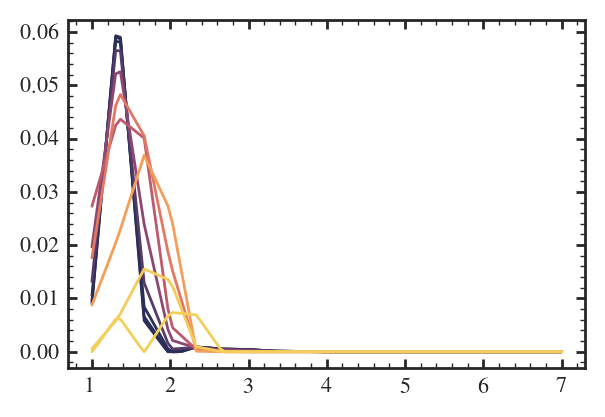

In [40]:
surp.yields.set_yields(agb_model="ventura13", mass_factor=1.5, no_negative=True)
y_agb = vice.yields.agb.settings["c"]

for Z in MH_to_Z(np.linspace(-3, 0.5, 10)):
    N = 100
    Ms = np.linspace(1, 7, N)
    ys = np.zeros(N)
    
    for i in range(N):
        ys[i] = y_agb(Ms[i], Z)
    
    plt.plot(Ms, ys, color=hmap(Z_to_MH(Z)))

# Convert nugrid into VICE-format data tables

In [8]:
import pandas as pd

In [9]:
cd ~/surp/carbon_paper/

/users/PAS2232/aeyobd/surp/carbon_paper


In [64]:
b19 = pd.read_csv("../data/nugrid_B19.txt", sep="\s+", skiprows=2, index_col=0)
b21 = pd.read_csv("../data/nugrid_B21.txt", sep="\s+", skiprows=2, index_col=0)

In [65]:
b19_ele = pd.DataFrame(columns=b19.columns)
for idx, row in b19.iterrows():
    ele, _ = idx.split("-")
    if ele in b19_ele.index:
        b19_ele.loc[ele] += row
    else:
        b19_ele = pd.concat([b19_ele, pd.DataFrame(row.to_dict(), index=[ele])])

In [66]:
b21_ele = pd.DataFrame(columns=b21.columns)
for idx, row in b21.iterrows():
    ele, _ = idx.split("-")
    if ele in b21_ele.index:
        b21_ele.loc[ele] += row
    else:
        b21_ele = pd.concat([b21_ele, pd.DataFrame(row.to_dict(), index=[ele])])

In [67]:
elements = "H, He, Li, B, C, N, O, F, Ne, Na, Mg, Al, Si, P, Pb, S, Cl, Ar, K, Ca, Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, Ga, Ge, As, Se, Br, Kr, Rb, Sr, Y, Zr, Nb, Mo, Ru, Rh, Pd, Ag, Cd, In, Sn, Sb, Te, I, Xe, Cs, Ba, La, Ce, Pr, Nd, Sm, Eu, Gd, Tb, Dy, Ho, Er, Tm, Yb, Lu, Hf, Ta, W, Re, Os, Ir, Pt, Au, Hg, Tl, Bi".split(", ")

In [87]:
raw = {}
yields = {}

for ele in elements:
    raw[ele] = pd.DataFrame()
    yields[ele] = pd.DataFrame()

with open("../data/element_yield_table_MESAonly_fryer12_delay_total.txt") as file:
    skip = 6
    M = None
    M_ej = None
    for line in file:
        if skip > 0:
            skip -= 1
            continue
            
        if line[:7] == "H Table":
            s1, s2 = line[10:].split(",")
            M = float(s1[2:])
            Z = float(s2[2:-2])
            skip = 1
            continue
            
        if line[:8] == "H Mfinal":
            M_rem = float(line[10:])
            M_ej = M - M_rem
            skip = 1
            continue
            
        if M_ej is None:
            continue
        
        _, ele, y, x0, _ = line.split("&")

        y = float(y)
        x0 = float(x0)
        xf = y/M_ej
        y_net_fractional = (xf - x0) * M_ej/M
        ele = ele.strip()
        
        row = pd.DataFrame({"mass":M, "M_rem":M_rem, "Z":Z, "y":y, "x0": x0}, index=[0])
        raw[ele] = pd.concat([raw[ele], row], ignore_index=True)
        
        row = pd.DataFrame({"mass":M, "Z":Z, "y":y_net_fractional}, index=[0])
        yields[ele] = pd.concat([yields[ele], row], ignore_index=True)

In [88]:
for ele in elements:
    raw[ele].set_index(["mass", "Z"], inplace=True)

In [89]:
# update the relevant models with B19 and B21
for ele in elements:
    b19r = b19_ele.loc[ele]
    b21r = b21_ele.loc[ele]
    for M, Z, b, key in [
        (2, 0.01, b19r, "m2z1m2"),
        (3, 0.01, b19r, "m3z1m2"),
        (2, 0.02, b19r, "m2z2m2"),
        (3, 0.02, b19r, "m3z2m2"),
        (2, 0.001, b21r, "m2z1m3-bigpoc"),
        (3, 0.001, b21r, "m3z1m3-bigpoc")
    ]:
        df = raw[ele]
        y = b[key]
        raw[ele].loc[(M, Z), :]["y"] = y

In [90]:
yields_old = {ele: df.copy() for ele, df in yields.items()}

In [91]:
for ele in elements:
    df = raw[ele]
    df["M"] = [a[0] for a in df.index]
    df["Z"] = [a[1] for a in df.index]
    M_ej = df.M - df.M_rem
    x_ej = df.y/M_ej
    y_net_frac = (x_ej - df.x0) * M_ej/df.M
    yields[ele]["y"] = y_net_frac.values

0     0.000000
1     0.000000
2     0.107214
3     0.008203
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.110833
15    0.226969
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.107688
39    0.100142
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000000
45    0.000000
46    0.000000
47    0.000000
48    0.000000
49    0.000000
50    0.000000
51    0.000000
52    0.000000
53    0.000000
54    0.000000
55    0.000000
56    0.000000
57    0.000000
58    0.000000
59    0.000000
Name: y, dtype: float64
0     0.000000
1     0.000000
2     0.048944
3     0.005346
4     0.000000
5

In [93]:
cd ../../VICE/vice/yields/agb/pignatari16/

/users/PAS2232/aeyobd/VICE/vice/yields/agb/pignatari16


In [94]:
for ele, table in yields.items():
    filename = "%s.dat" % (ele.lower())
    df = table[table.mass < 8].sort_values(by=["mass", "Z"])
    df.to_csv(filename, sep="\t", index=False, header=False)